# ML 4 Timeseries: Mortality Prediction
In this lab you will learn and implement a basic machine learning pipeline for time-series analysis mortality  prediction using ScikitLearn.

Lab designed by: Andrew Creagh andrew.creagh@eng.ox.ac.uk | Anshul Thaker anshul.thaker@eng.ox.ac.uk<br>
For more details on the lab, please see our [github repository](https://github.com/apcreagh/CDTworkshop_ML4timeseries)

## Your tasks:
1. Visualse the distribution of features & an example over time
2. Generate statistical summary features
    - $\bar{\mathbf{x}}$
    - $\bar{\mathbf{x}}$ $\pm$ $\sigma$
    - $\bar{\mathbf{x}}$ $\pm$ $\tilde{\mathbf{x}}$
3. Implement stratified k-fold cross validation
4. Apply the necessay pre-processing steps 
    - normalisation
    - outlier removal: mean imputation
5. Train two off-the-shelf machine learning models for mortality prediction. 
    - Train a linear model, e.g. Logistic Regression
    - Train a non-linear model, e.g. Random Forest
6. Evaluate the model
    - Compare between model perfromance
    - Determine the important features for mortality prediction
    - Compare model performance between various types of features
7. Re-implement time-series specific features
    - $\mathbf{a}_{l}$, the autocorrelation coefficients at various time lags, $l$
    - feel free to come up with your own, for example windowing the time-series
    - train your models again and compare model performance between statistcial and time-series feature types

In [1]:
import numpy as np
import pandas as pd
import os
import math
import warnings
import itertools
#import numbers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os
import pickle
from os.path import expanduser
home = expanduser("~")

## Load the data:
The data (``X_data.npy``) is is stored as $\mathbf{X} \in \mathbb{R}^{N\times T \times P}$, where $N$ are the number of patients, $T$ are the number of time-steps and $P$ are the number of features. A corresponding column vector of labels (``y_data.npy``), $\mathbf{y} \in \mathbb{R}^{N\times 1}$, denote patient mortality at time $T+1$ A list of the clinical measurement names (i.e. the features) are stored in ``feature_names.txt``

In [2]:
'''load the data'''
X=np.load('../../data/X_data.npy')
y=np.load('../../data/y_data.npy')
feature_names=pd.read_csv('../../data/feature_names.txt').to_numpy().reshape(-1)

print('X shape (N x T x P):', X.shape)
print('y shape:', y.shape)
print('number of features', len(feature_names))
print('features names:',feature_names)

X shape (N x T x P): (9622, 48, 59)
y shape: (9622,)
number of features 59
features names: ['Diastolic blood pressure' 'GCS (total)' 'GCS 10' 'GCS5' 'GCS_1' 'GCS_11'
 'GCS_12' 'GCS_13' 'GCS_14' 'GCS_15' 'GCS_16' 'GCS_17' 'GCS_18' 'GCS_19'
 'GCS_2' 'GCS_20' 'GCS_21' 'GCS_22' 'GCS_23' 'GCS_24' 'GCS_24' 'GCS_25'
 'GCS_26' 'GCS_27' 'GCS_27' 'GCS_28' 'GCS_29' 'GCS_3' 'GCS_30' 'GCS_31'
 'GCS_32' 'GCS_33' 'GCS_34' 'GCS_35' 'GCS_35' 'GCS_36' 'GCS_37' 'GCS_38'
 'GCS_38' 'GCS_38' 'GCS_39' 'GCS_4' 'GCS_40' 'GCS_6' 'GCS_7' 'GCS_8'
 'GCS_9' 'Heart Rate' 'Height' 'ICU_Cardiac Surgery Recovery Unit'
 'ICU_Coronary Care Unit' 'Mean blood pressure' 'Oxygen saturation'
 'Respiratory rate' 'Sex' 'Systolic blood pressure' 'Temperature' 'Weight'
 'pH']


We can see that the features are various physiological measurements, such as heart rate, blood pressure and respiratory rates. Other measurements include the patient's demographics, such as sex, or physical attributes such as weght and height. A clinican-rated scoring system is also recorded, known as the Glasgow Coma Scale (GCS). These consist questions from three domains, (1) Eye response, (2) Verbal response (3) Motor response. These features and sub-domains have been coded as binary response or categorical variables. For more information see
https://www.glasgowcomascale.org/

## 1. Task: Visualse the distribution of features & an example over time
- <b>Hint</b>: summerise the features over time first using the median or mean

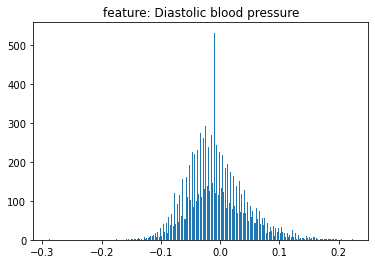

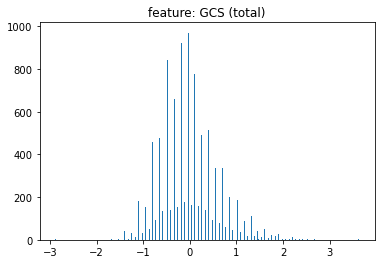

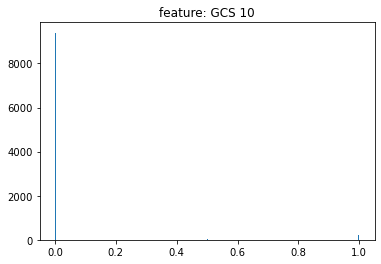

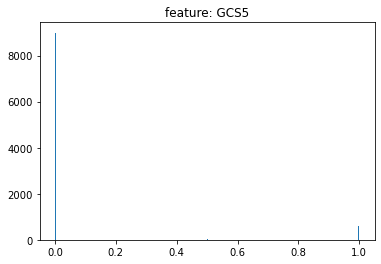

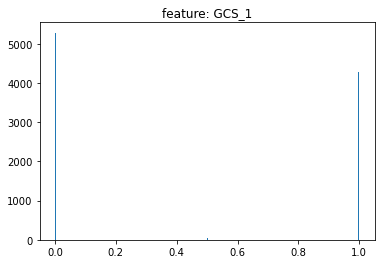

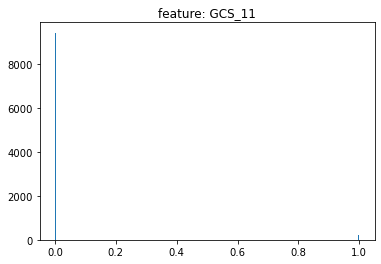

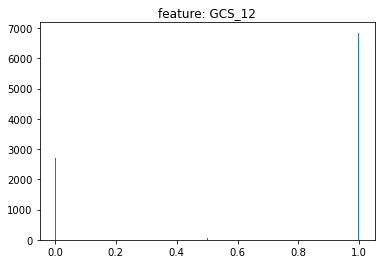

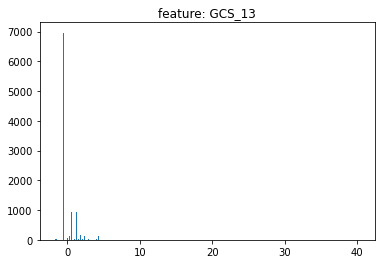

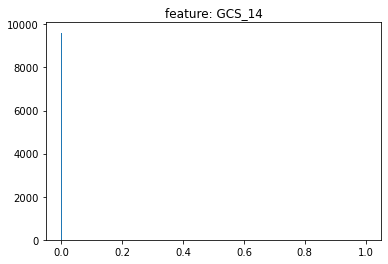

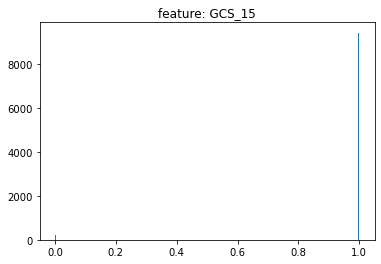

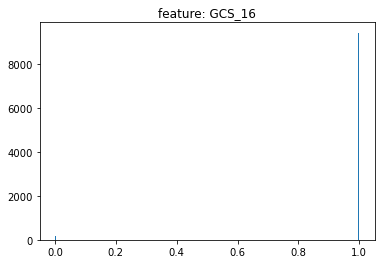

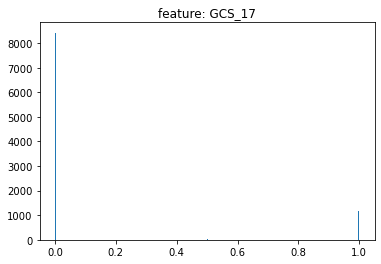

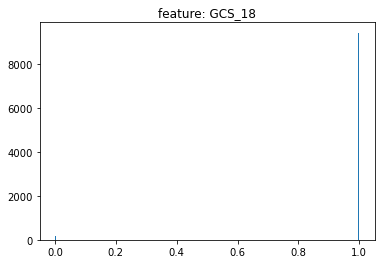

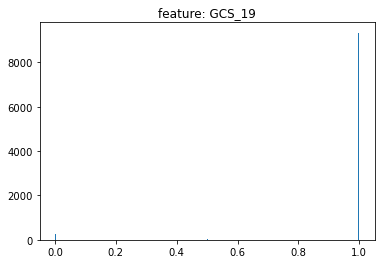

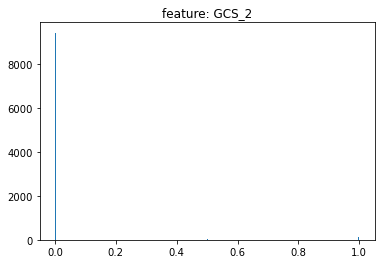

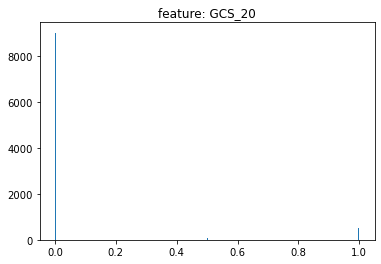

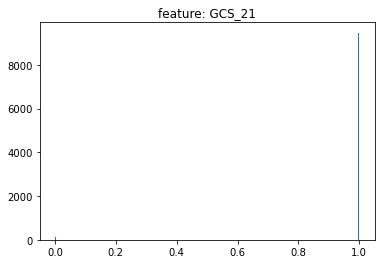

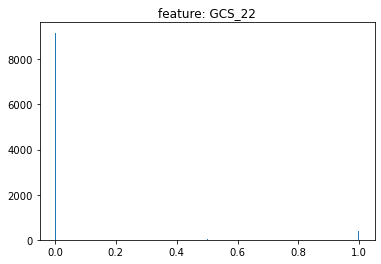

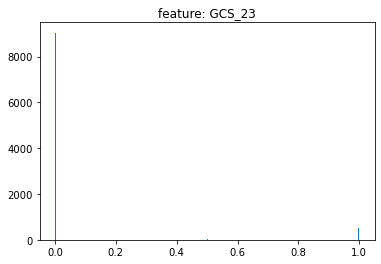

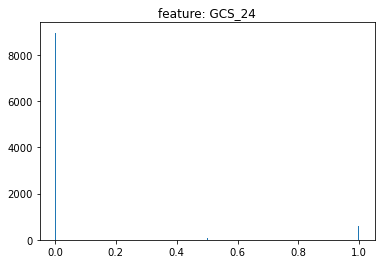

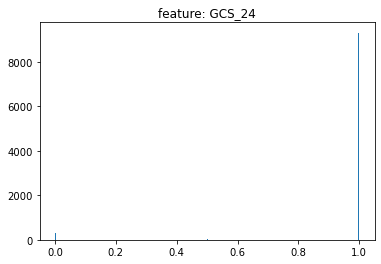

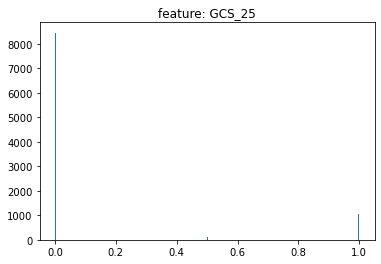

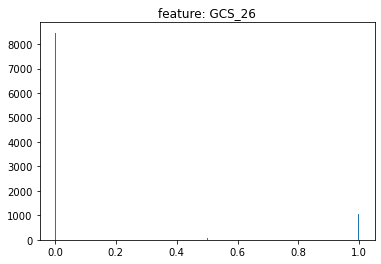

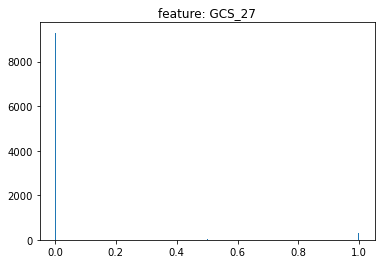

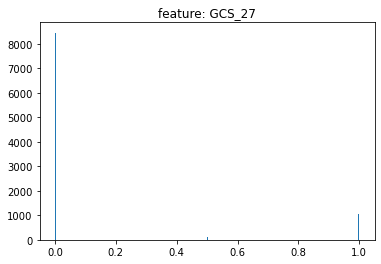

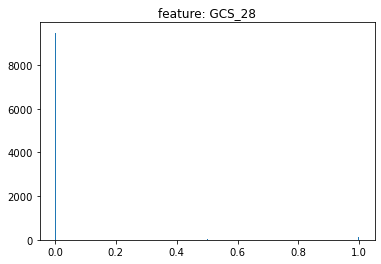

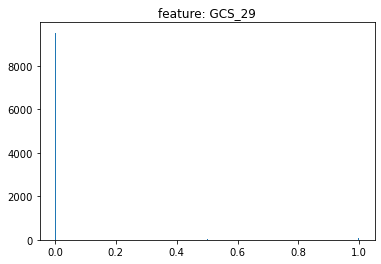

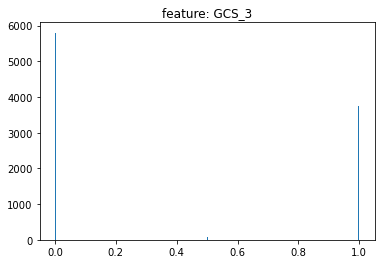

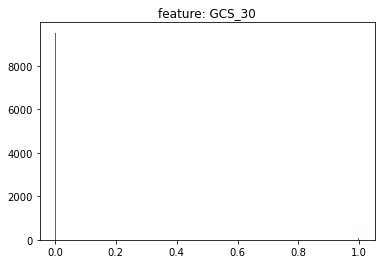

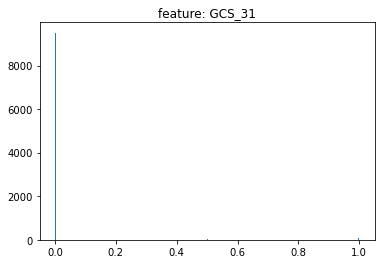

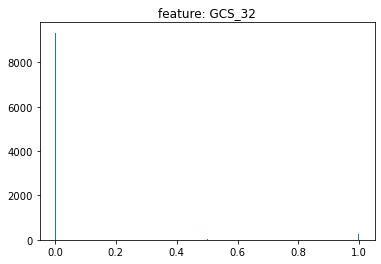

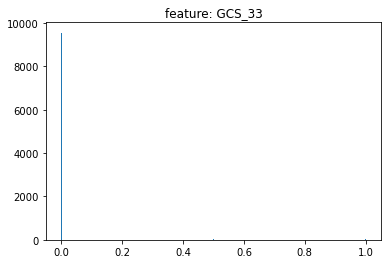

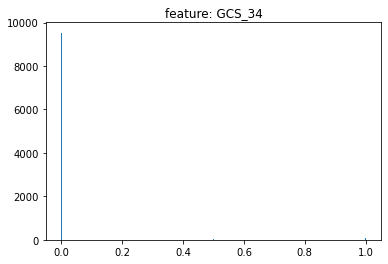

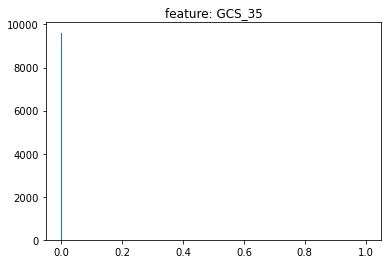

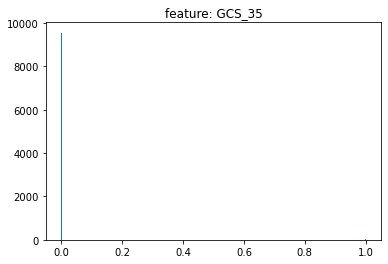

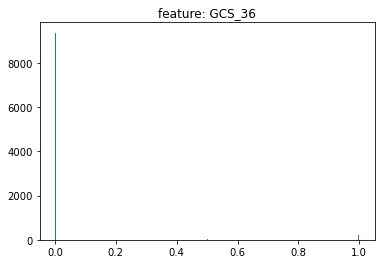

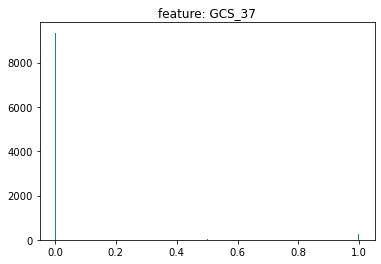

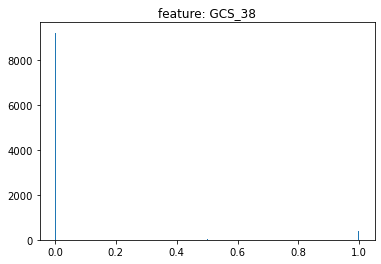

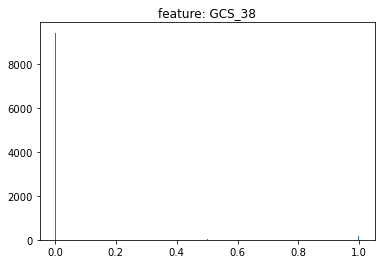

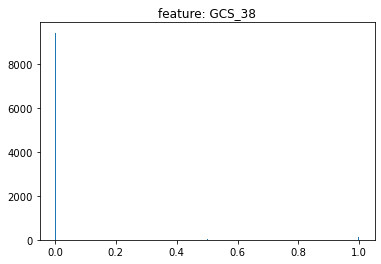

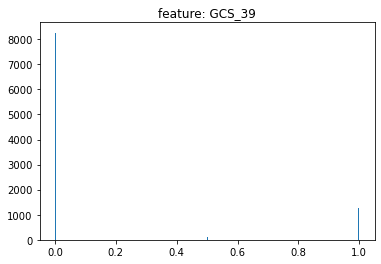

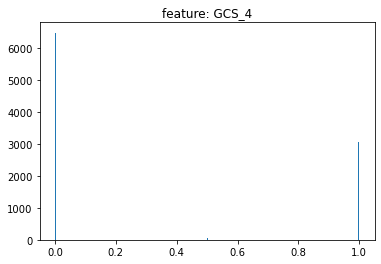

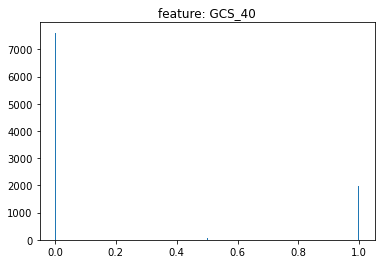

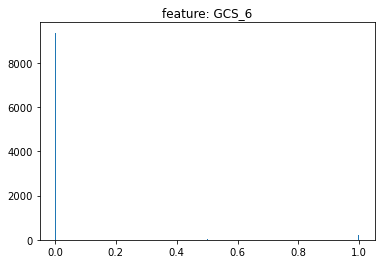

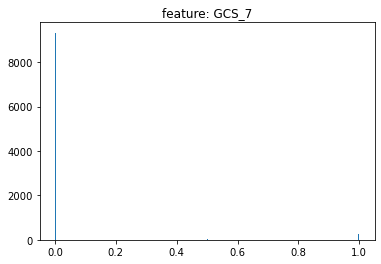

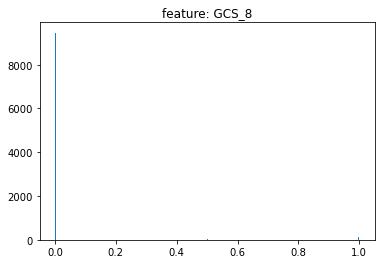

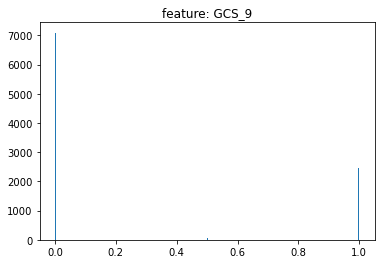

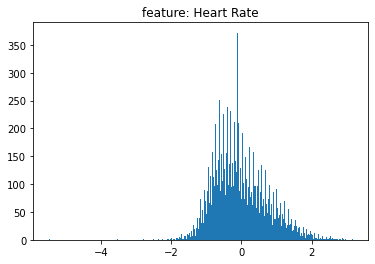

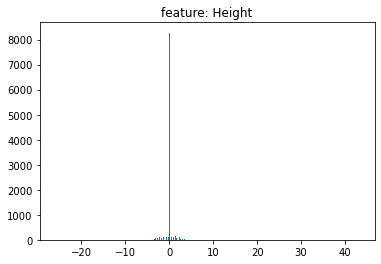

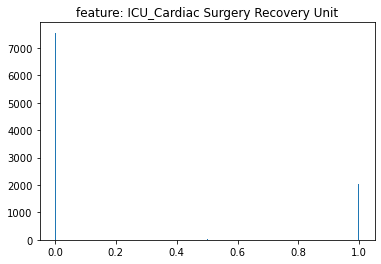

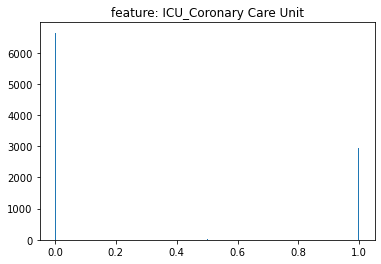

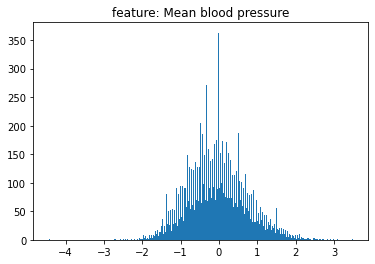

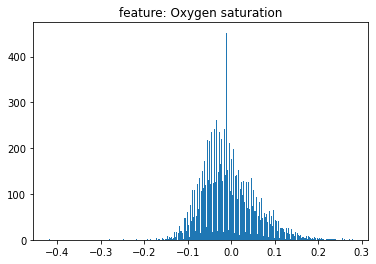

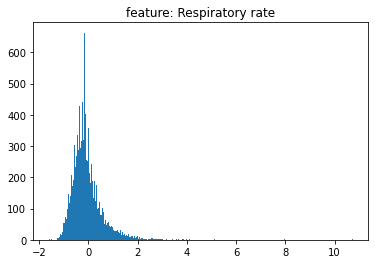

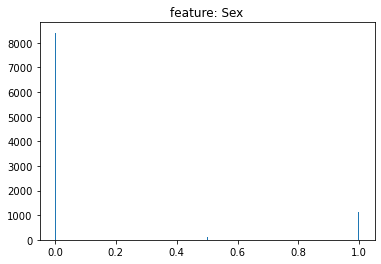

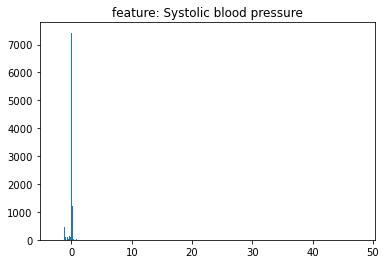

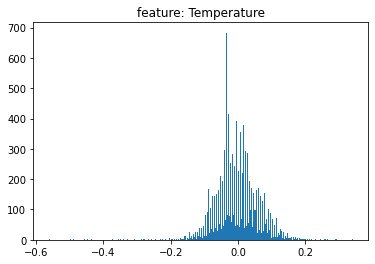

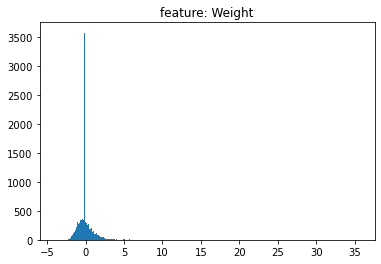

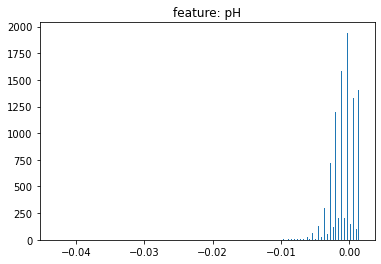

In [33]:
'''Solution'''
#take the median over the timesteps
X_med=np.median(X, axis=1)

for f in range(X_med.shape[1]):
    plt.hist(X_med[:, f],bins=300)
    plt.title('feature: ' + str(feature_names[f]))
    plt.show()


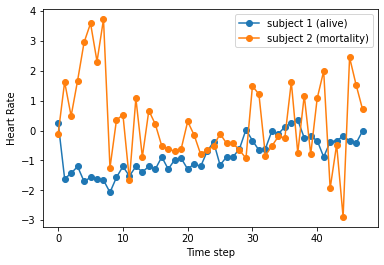

In [4]:
'''Solution'''
example_alive=np.where(y==0)[0][0]
example_mort=np.where(y==1)[0][0]


plt.plot(X[example_alive, :, feature_names=='Heart Rate'].squeeze(), 'o-', label='subject 1 (alive)')
plt.plot(X[example_mort, :, feature_names=='Heart Rate'].squeeze(), 'o-', label='subject 2 (mortality)')

plt.ylabel('Heart Rate')
plt.xlabel('Time step')
plt.legend()
plt.show()

## 2. Task: Generate summary features & time-series specific features:

In [5]:
'''feature extraction'''
#the mean
X_m=np.mean(X, axis=1)

#the variance
X_sd=np.std(X, axis=1)

#the delta
X_delta=(X[:, -1, :]-X[:, 0, :])/np.std(X, axis=1)
X_delta[np.isnan(X_delta)]=0

#(1) mean feature value
X_data_1=X_m
feature_names_1=feature_names
print('new fetaure matrix shape (mean):\nX data', X_data_1.shape)

'''hint: concatonate the features together into a new feature matrix and create a new vector with the feature names (i.e. the mean, the variance, etc.)'''
#(2) mean feature value + variability of feature
X_data_2=np.concatenate((X_m, X_sd), axis=1)
feature_names_2=np.concatenate((feature_names + '(mean)', feature_names + '(std)'), axis=0)
print('new fetaure matrix shape (mean + sd):\nX data', X_data_2.shape)

#(3) mean feature value + slope of feature
X_data_3=np.concatenate((X_m, X_delta), axis=1)
feature_names_3=np.concatenate((feature_names + '(mean)', feature_names + '(delta)'), axis=0)
print('new fetaure matrix shape (mean + slope):\nX data', X_data_3.shape)

new fetaure matrix shape (mean):
X data (9622, 59)
new fetaure matrix shape (mean + sd):
X data (9622, 118)
new fetaure matrix shape (mean + slope):
X data (9622, 118)


<ipython-input-5-d99e8a4aef53>:9: RuntimeWarning: invalid value encountered in divide
  X_delta=(X[:, -1, :]-X[:, 0, :])/np.std(X, axis=1)


## Task: Implement stratified k-fold cross validation
Split the data into training and validation, test sets
- <b>Hint</b>, get the pipleine running with one split only, they merge your pipeline into a loop
- the code below demonstrates how to ranomly split the data (non k-fold)
- Either manually create a k-fold validation split, or use ScikitLearn's functions:
https://scikit-learn.org/stable/modules/cross_validation.html#stratification
- <b>Hint</b>: make sure the distributions are stratifed between train, validation and test

In [6]:
'''example of making one split, using mean features'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_1, y, test_size=0.33, random_state=42, stratify=y)

In [7]:
'''task: implement stratified k-fold cross validation'''

'task: implement stratified k-fold cross validation'

In [8]:
'''solution: implement stratified k-fold cross validation'''

'solution: implement stratified k-fold cross validation'

```
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
skf = StratifiedKFold(n_splits=5)
for X_train, X_test in skf.split(X_data_1, y):
    ...
    #train your model
```

In [9]:
'''helper function to calculate class distributions'''
import collections
def calculate_class_distributions(labels, numeric_labels, response):
    
    counter=collections.Counter(sorted(response))
    counts=np.array(list(counter.values()))
    keys=np.array(list(counter.keys()))

    print('Distribution : n={:6.0f}'.format(len(response)))
    for ix, label in enumerate(labels):
        print('{}: {:10s}: n={:6.0f} ({:3.2f}%)'.format(keys[ix], label, counts[ix], counts[ix]/len(response)*100))

    return counter

print('Training')
calculate_class_distributions(labels=['alive','mortality'], numeric_labels=[0, 1], response=y_train);
print('Testing')
calculate_class_distributions(labels=['alive','mortality'], numeric_labels=[0, 1], response=y_test);

Training
Distribution : n=  6446
0: alive     : n=  5343 (82.89%)
1: mortality : n=  1103 (17.11%)
Testing
Distribution : n=  3176
0: alive     : n=  2633 (82.90%)
1: mortality : n=   543 (17.10%)


We have uneven distributions of alive after timestep $T+1$ versus a mortality, we therefore have to consider modeling this as an imbalanced data problem;


## 3. Task: Apply the necessay pre-processing steps 
    - normalisation
    - outlier removal: mean imputation

In [10]:
'''task: normalisation'''
def zscore_data(x):
    '''...write a function to standardise the data using the zscore'''
    return x 

X_test=zscore_data(X_test)
X_train=zscore_data(X_train)

In [11]:
'''solution: normalisation'''
def zscore_data(x):
    '''...write a function to standardise the data using the zscore'''
    x_=x.copy()
    for i in range(x.shape[1]):
        x_[:, i]=(x_[:,i]-np.mean(x_[:, i]))/np.std(x_[:, i])
    x=x_
    return x 

X_test=zscore_data(X_test)
X_train=zscore_data(X_train)

'''alternative method of normalising, using ScikitLearn's function''' 
#from sklearn.preprocessing import StandardScaler
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

"alternative method of normalising, using ScikitLearn's function"

Perform outlier removal using the following cases:
$$
x_i=\begin{cases}
			\bar{\mathbf{x}}, & \text{if $x_i$ > $\bar{\mathbf{x}} \pm (\alpha\times\sigma)$}\\
            x_i, & \text{otherwise}
		 \end{cases}, \forall \ \mathbf{x} \in \mathbf{X}
$$

In [12]:
'''task: outlier removal'''
# - impute as the mean value if the feature value is > mean + threshold*std
def remove_outliers(X, sd_threshold=5):
    '''...write a function to remove the outliers in the data'''
    return X

X_train=remove_outliers(X_train)

In [13]:
'''solution: outlier removal'''
# - impute as the mean value if the feature value is > mean + threshold*std
def remove_outliers(X, sd_threshold=5):
    
    nrem=[]
    for f in range(X.shape[1]):
        mu=np.mean(X[:, f])
        sigma=np.std(X[:, f])
        threshold= + sd_threshold*sigma
        
        idx=X[:, f] > threshold
        X[idx]=mu
        nrem.append(sum(idx))
     
    nrem=np.array(nrem)
    return X, nrem

X_train, nrem=remove_outliers(X_train)
X_test, _=remove_outliers(X_test)

## Task: Train and compare two off-the-shelf machine learning models (linear model)
In this section we will now train our off-the-shelf machine leanring (ML) model. A great starting point is to use a simple linear model, such as logistic regression, which essentially describes a linear regression with a (non-linear) logistic output to perform classification. 

- You are free to use any machine learning model you wish, or compare between models

### Background

#### Linear Regression
A linear regression model explicitly describes a relationship between predictor(s) $\mathbf{X} \in \mathbb{R}^{N\times P}$ and continuous response variables $\mathbf{y} \in \mathbb{R}^{N}$. For an $i^{th}$ observation row of $\mathbf{X}$, $\mathbf{x}\equiv\mathbf{x_i}\in\mathbb{R}^{1\times P}$:
\begin{align}
        \hat{y} &=w_0 + w_1x_1 + w_2x_2+\dotsc+w_Px_P + \epsilon\\
        &=w_0 + \sum_{j=1}^Pw_jx_j + \epsilon\\
        &=\mathbf{w}^\top\mathbf{x} + b \\
        &=\mathbf{w}^\top\mathbf{x}
\end{align}
where $w_j$ values denote the slope (weights, or regression coefficients) of the $x_j$ features; $w_0$ is the intercept term; and $\epsilon$ denote the residual (model) errors term, which are assumed to be normally distributed with constant variance, $\epsilon\sim\mathcal{N}(0,\sigma^2)$ [1,2-3]. Often a linear model is described in vector notation, $\mathbf{w}=[w_1, w_2, ..., w_P]$, where $w_0$ is denoted as the <em>bias</em>, $b$ term, and the $\epsilon$-term is often omitted. More succinctly, a linear model can be also represented by the equation $\mathbf{w}^\top\mathbf{x}$, where $\mathbf{w}=[w_0, w_1,w_2,...,w_{P+1}]$ is a vector of regression coefficients, including $w_0$ (or $b$) as the first value and $\mathbf{x}\in\mathbb{R}^{1\times(P+1)}$ which is first concatenated with a vector column of ones to account for $w_0$ (or $b$) in $\mathbf{w}$ at the first index. 

#### Logistic Regression
 Generalised linear models (GLMs) are extensions of linear regression models that can have non-linear outputs [2]. GLMs utilise canonical link functions, $\phi$, to transform the outputs of a linear regression:  $\varphi=\mathbf{w}^\top\mathbf{x}$ to another distribution, such as with a logistic $\phi = \sigma(\varphi)$ link function (or inversely the logit, representing the log-odds) which will be used to form Logistic Regression for binary classification tasks [1,2]:
 \begin{equation}
     \sigma(x)=\frac{1}{1+e^{-x}}
 \end{equation}
 in this case $\phi$ is sigmoidal and is bounded between $[0,1]$, therefore the output of $\sigma$ can be interpreted as the probability of $y=1$: 
 \begin{equation}
    p(\mathbf{x}; \mathbf{w})=\frac{1}{1+e^{-(\mathbf{w^\top}\mathbf{x})}}
\end{equation}
A threshold can be applied to the probabilistic output $p$ to determine a classification prediction $\hat{y}$ for a Logistic Regression model; threshold values are typically chosen as 0.5, but this can be altered based on the use case.  

#### Regularisation $\rightarrow$ Feature Selection
Many statistical and machine learning models can easily overfit to the training data, resulting in poorer estimations, models that are not generalisable or too complex. Regularisation is often introduced to mitigate against this. For example large coefficient values in a regression can be penalised by adding a regularisation term to a loss function, or through reducing the number of parameters or features used in a model. The most common regularisers use the $\ell_p$-norm defined by [1,5]:
\begin{equation} \label{eq:methods:lp-norm}
||\mathbf{x}||_p=\left(\sum_{i=1}^N|x_i|^p\right)^{1/p}
\end{equation} 
for any $\mathbf{x}\in\mathbb{R}^{N\times1}$, where the real number $p\geq1$ defines the $\ell_p$ space.

#### LASSO for Logistic Regression
The Least Absolute Shrinkage and Selection Operator (LASSO) [5-6] is a technique that conversely solves the  $\ell_1\mathrm{-penalised}$ sum of squares in a linear regression such that:
$$
    \hat{\mathbf{w}} =\underset{\mathbf{w}}{\operatorname{argmax}}\left\{\sum_{i=1}^N|y_i-w_0\sum_{j=1}^{P}w_{j}x_{ij}|^2 + \lambda\sum_{j=1}^P|w_j|\right\}
$$
This is equivalent to minimising the sum of squares with a constraint of the form: $||w||_1 = \sum_{j}^N|w_j|\leq t$. 
Because of the form of the $\ell_1$-penalty, LASSO both shrinks coefficients but also encourages sparsity in a model's parameters and thus inherently forms feature selection, shrinking non-important features to zero. 

The LASSO can also be extended to perform feature selection for classification by substituting a canonical link function (such as the logistic $\phi=\sigma(\varphi)$ and following the same procedure, essentially performing regularised-logistic regression [3]).

LASSO regularisation for logistic regression can therefore be employed in order to reduce the dimensions of the extracted feature space into a ranked parsimonious set. 

In [14]:
'''run logistic regression with l1 regularisation (i.e. LASSO)'''
from sklearn.linear_model import LogisticRegression
LAMBDA=0.01 

clf_l1_LR=LogisticRegression(random_state=42, penalty='l1', C=LAMBDA, solver="saga", tol=0.001, class_weight='balanced')
clf_l1_LR.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga', tol=0.001)

<b>hint</b> use the ``class_weight='balanced'`` parameter to account for imbalanced data in the loss fucntion. 

## Ancillary task: 
- optimse over $\lambda$ values (i.e. parameter C), using internal cross-validation using training and validation sets

## Task: Train and compare two off-the-shelf machine learning models (non-linear model)

### Random Forest
Classification and Regression Trees (CART) specifically Random Forests (RF) are a multi-functional, non-linear method capable of performing regression, classification and feature selection [1,4]. Unlike the linear filter-based methods of feature selection introduced thus far, for example, LASSO (which are also often used to (linearly) pre-select features prior to application in (non-linear) methods, such as SVMs), RFs incorporate non-linear feature selection as part of the model methodology. 

*Below is a simple diagram describing the construction of a Random Forest (RF) model.*
  ![../img/RF_schematic.png](RF_schematic.png)

Random Forests consist of a large ensemble of decision trees arranged in a hierarchical structure, as depicted in figure \ref{fig:methods:rf}. To build an individual tree, we recursively descend through the hierarchy, performing binary splits (decisions) at each level in the structure (a node, $j$) using a single feature $x_j\in\mathcal{X}^p$ based on a threshold value (splitting criterion) $s_j$, sub-partitioning the feature space $\mathcal{X}_j$ at each node. A tree is typically expanded until all leaves are pure (i.e each partition $\mathcal{X}_j$ represents only one class) or until all leaves contain less than the minimum number of samples in a partition $\mathcal{X}_j$ required to split a node. While decision trees are susceptible to over-fitting, the advantage of a RF is that multiple trees can be learned, introducing a variability between the trees. An individual tree selects $m<N$ random subset of observations (with replacement), and each node considers a random subset of $p$ features for each split. Importantly, the same feature can be selected for multiple nodes in the tree, and can have different associated $s_j$ values at each node. Once all trees have been grown, each of the <em>weaker</em> decisions are aggregated (or \textit{ensembled}) creating a robust final prediction. 
Classification predictions are deduced as the majority class label of the observations present in each final partition $\mathcal{X}_j$, whereas for continuous prediction (i.e. regression) the mean of the (continuous) responses would be calculated instead. To determine the optimal split criterion $s_j$ for each $x_j$ to create each $\mathcal{X}_j$ we evaluate the \textit{Gini} importance, which quantifies the average gain of purity (i.e. the presence of one class) caused by splits of a given variable.
RFs have relatively little hyperparamater tuning, which typically only include the number of trees to build ($k=1500$ in this thesis) and the number of input variables chosen at each node ($p$). Values of $p$ are suggested in [8] are: $p \in \{\sqrt{P}, 2\sqrt{P}, \sqrt{P}/2 \}$.

### Balanced Random Forest
In this example we utalise a balanced Random Forest: `BalancedRandomForestClassifier`, which randomly under-samples each boostrap sample to balance the classes during training. For more details see: https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

In [15]:
'''balanced Random Forest'''
from imblearn.ensemble import BalancedRandomForestClassifier

clf_RF = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf_RF.fit(X_train, y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    3.4s finished


BalancedRandomForestClassifier(n_estimators=2000, n_jobs=4, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

## Task: Evaluate the model(s)

In [16]:
'''helper functions to compute evluation metrics'''
import sklearn.metrics as metrics

def get_one_hot(targets, nb_classes):
    '''numpy version'''
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def compute_scores(y_true, y_pred, y_prob=None):
    ''' Compute a bunch of scoring functions '''
    auc=np.nan
    confusion = metrics.confusion_matrix(y_true, y_pred)
    per_class_recall = metrics.recall_score(y_true, y_pred, average=None)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1=metrics.f1_score(y_true, y_pred, pos_label=1)
    balanced_acuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    kappa = metrics.cohen_kappa_score(y_true, y_pred)
    if y_prob is not None:
        auc=metrics.roc_auc_score(get_one_hot(y_true,  y_prob.shape[1]), y_prob)
    return {
        'confusion': confusion,
        'per_class_recall': per_class_recall,
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acuracy,
        'kappa': kappa,
        'F1': f1, 
        'AUROC': auc,
    }

def print_scores(scores):
    print('Accuracy: {:.3f} | Balanced Accuracy: {:.3f} | AUROC: {:.3f} | Kappa: {:.3f} | F1: {:.3f}'.format(scores['accuracy'], scores['balanced_accuracy'], scores['AUROC'], scores['kappa'], scores['F1']))

#### (1) Evaluate LASSO-Logistic Regression

In [17]:
'''evalute the logistic regression model'''
y_train_pred = clf_l1_LR.predict(X_train)
y_test_pred = clf_l1_LR.predict(X_test)
y_test_prob = clf_l1_LR.predict_proba(X_test) 

print('Logstic Regression')
print_scores(compute_scores(y_test, y_test_pred, y_test_prob))

Logstic Regression
Accuracy: 0.637 | Balanced Accuracy: 0.704 | AUROC: 0.734 | Kappa: 0.242 | F1: 0.432


confusion matrix


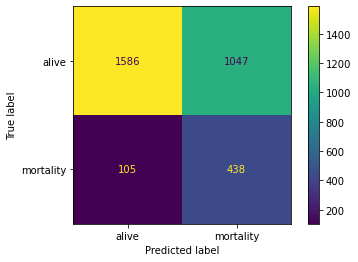

normalised confusion matrix


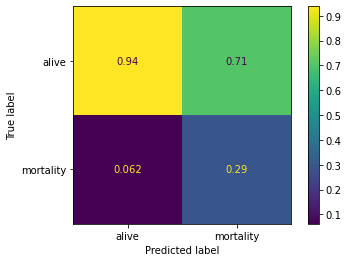

In [18]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labelstr=['alive', 'mortality']
CM=confusion_matrix(y_test,y_test_pred, )
nCM=CM/sum(CM[:])

disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                    display_labels=labelstr)
print('confusion matrix')
disp.plot();plt.show()

ndisp = ConfusionMatrixDisplay(confusion_matrix=nCM,
                    display_labels=labelstr)
print('normalised confusion matrix')
ndisp.plot(); plt.show()

#### (2) Evaluate Balanced Random Forest

In [19]:
y_train_pred = clf_RF.predict(X_train)
y_test_pred = clf_RF.predict(X_test)
y_test_prob = clf_RF.predict_proba(X_test) 

print('Random Forest')
print_scores(compute_scores(y_test, y_test_pred, y_test_prob))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 

Random Forest
Accuracy: 0.594 | Balanced Accuracy: 0.717 | AUROC: 0.796 | Kappa: 0.232 | F1: 0.432


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.2s finished


confusion matrix


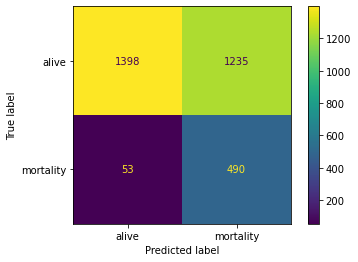

normalised confusion matrix


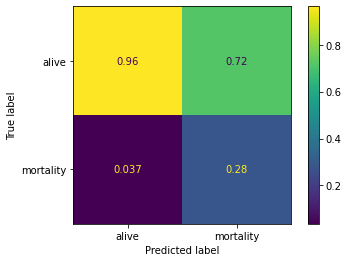

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labelstr=['alive', 'mortality']
CM=confusion_matrix(y_test,y_test_pred, )
nCM=CM/sum(CM[:])

disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                    display_labels=labelstr)
print('confusion matrix')
disp.plot();plt.show()

ndisp = ConfusionMatrixDisplay(confusion_matrix=nCM,
                    display_labels=labelstr)
print('normalised confusion matrix')
ndisp.plot(); plt.show()

## Task: Determine the important features for mortality prediction

### (1) Feature Importance: LASSO-Logistic Regression

In [21]:
'''determine the remaning number of important features'''
coef_l1_LR = clf_l1_LR.coef_.ravel()
sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
print('Total number of features: {:}\nNumber of features retained: {:}\nNumber of features removed: {:}\nSparsitiy introduced: {:.2f}%'. format(len(coef_l1_LR), np.sum(coef_l1_LR != 0), np.sum(coef_l1_LR == 0), sparsity_l1_LR))

#create a feature ranking table
data=np.transpose([feature_names_1, coef_l1_LR, np.absolute(coef_l1_LR)])
FEATURE_RANKING=pd.DataFrame(data=data, columns=['feature_name', 'coef', 'abs(coef)'])
#order by best -> worst
FEATURE_RANKING.sort_values(by=['abs(coef)'],  ascending=False)

Total number of features: 59
Number of features retained: 13
Number of features removed: 46
Sparsitiy introduced: 77.97%


,feature_name,coef,abs(coef)
6,GCS_12,-0.437546,0.437546
4,GCS_1,-0.387856,0.387856
1,GCS (total),0.236727,0.236727
47,Heart Rate,-0.206821,0.206821
54,Sex,-0.180428,0.180428
50,ICU_Coronary Care Unit,-0.169119,0.169119
53,Respiratory rate,0.148057,0.148057
49,ICU_Cardiac Surgery Recovery Unit,-0.082302,0.082302
8,GCS_14,0.077749,0.077749
3,GCS5,0.07413,0.07413


We can see that the Glasgow Coma Scale (GCS) total score an important predictor of mortality. Other physiological measurements such as the patient's heart rate, temperature, pH or blood pressure are also identifed as predictive of mortality.

### (2) Feature Importance: Random Forest

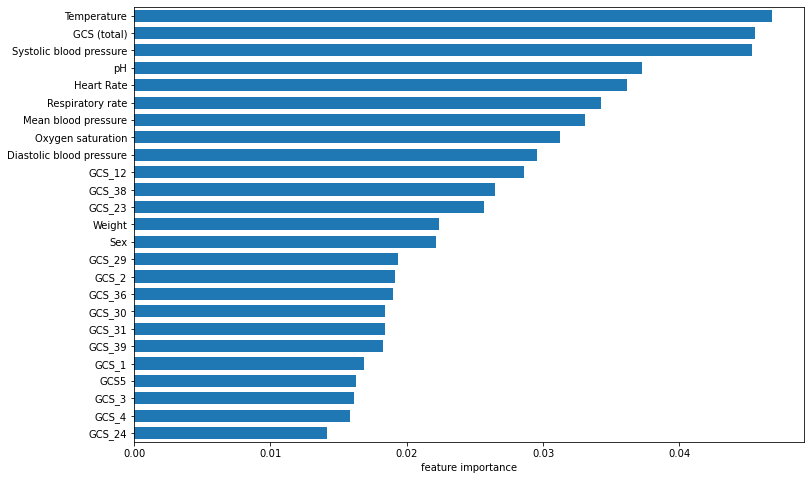

In [22]:
tree_importance_sorted_idx = np.argsort(clf_RF.feature_importances_)
feature_importance=clf_RF.feature_importances_[tree_importance_sorted_idx]
tree_indices = np.arange(0, len(feature_importance)) + 0.5

#take the first 25 features
nfeats=25
tree_importance_sorted_idx=tree_importance_sorted_idx[-nfeats:]
feature_importance=feature_importance[-nfeats:]
tree_indices = np.arange(0, nfeats) + 0.5


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.barh(tree_indices,
         feature_importance, height=0.7)
ax.set_ylim((0, len(tree_indices)))
ax.set_yticks(tree_indices)
ax.set_yticklabels(feature_names_1[tree_importance_sorted_idx])
ax.set_xlabel('feature importance')
plt.show()

Again, we can see that the Glasgow Coma Scale (GCS) total score is the most important predictor of mortality. Other physiological measurements such as the patient's heart rate, temperature, or blood pressure are also identifed as predictive of mortality.

# Task: Re-implement time-series specific features 
For this example, we will implement use the assumptions of autoregressive models (AR) to evaluate time-series specific features. We can estimate the relationship between the value at any point $t$, $x_t$, and the value at any point $(t-1)$, $x_{t-1}$ using:

\begin{equation}
    AR(1)=x_t\approx a_1x_{t-1}+c
\end{equation}

where $a_1$ are the weights of the model and c is the constant. $AR(1)$ denotes that this is a first order model.


We can compute the autocorrelation within the time-series $\mathbf{x}\in\mathbb{R}^{1\times N}$ [9, 10]. The autocorrelation function measures the correlation between $x_t$ and $x_{t+k}$, at various lags, $k$, where $k = 0,\ldots,K$. The autocorrelation for lag $k$ is: 
\begin{equation}a_k=\frac{c_k}{c_0} \end{equation} 

\begin{equation} c_k=\frac{1}{T}\sum\limits_{t=1}^{T-k}(x_t - \mathbf{\bar{x}})(x_{t+k}-\mathbf{\bar{x}}) \end{equation}
where $\mathbf{\bar{x}}$ is the mean of $\mathbf{x}$; $c_0$ is the sample variance of the time-series.


In this work we can extract the auto-correlation of some physiological measurement at various lags, $k$, in order to extract information about stochasticity. 

First pull out the continous feature values, i.e. the physiological measurements such as heart rate and respiratoration. 

In [23]:
fidx=np.isin(feature_names, ['Heart Rate', 'Respiratory rate', 'Mean blood pressure', 'Systolic blood pressure', 'Diastolic blood pressure', 'Temperature', 'Oxygen saturation'])
X_=X[:, :, fidx]
print('X data (shape)', X_.shape)

X data (shape) (9622, 48, 7)


In [24]:
'''define our autocorrelation function (ACF)'''
#see https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation 
def autocorrelation(x,nlags=15):
    '''normalised, full autocorrelation'''
    lags=np.arange(nlags)
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

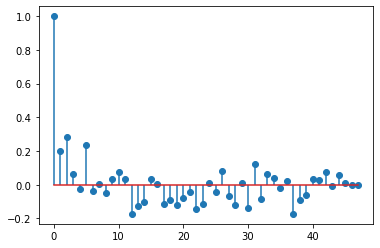

In [25]:
'''plot the autocorrelation for varying time lags'''
xx=X[example_mort, :, feature_names=='Heart Rate'].squeeze()
nlags=np.floor(len(xx)).astype(int)
lags=np.arange(nlags)

r=autocorrelation(xx, nlags=nlags)
plt.stem(r)
plt.show()

We can see the autocorrelation of the heart rate for varying time lags. Below we can use the statsmodels.py plots to generate an ACF with confidence limits. See https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html for more details

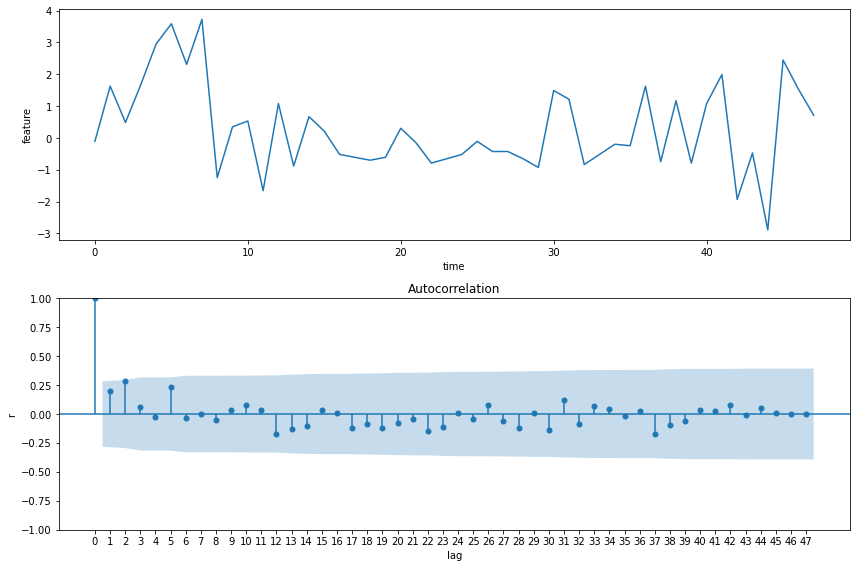

In [26]:
'''plot the autocorrelation for varying time lags'''
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(xx)

ax1.set_ylabel('feature')
ax1.set_xlabel('time')

# Use the Autocorrelation function
# from the statsmodel library passing
plot_acf(x=xx,  lags=lags, ax=ax2)

ax2.set_ylabel('r')
ax2.set_xlabel('lag')
ax2.set_xticks(lags)

fig.tight_layout()
plt.show()

Next we can extract autocorrelation features over entire dataset of continuous feature values, i.e. the physiological measurements such as heart rate and respiratoration. 

In [27]:
'''extract autocorrelation features over the data'''
def extract_autocorr_features(data, nlags):
    '''function to extract autocorrelation features on a data matrix'''
    rcorr = np.zeros((data.shape[0], nlags, data.shape[2]))
    for i, x in enumerate(data):
        x=np.transpose(x)
        for j, xx in enumerate(x):
            rcorr[i, :, j]=autocorrelation(xx, nlags=nlags)       

    rcorr[np.isnan(rcorr)]=0        

    return rcorr

nlags=np.floor(X_.shape[1]/2).astype(int)
XAC=extract_autocorr_features(X_, nlags=48)

<ipython-input-24-a15149d2ac5b>:9: RuntimeWarning: invalid value encountered in divide
  corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)


We can then combine these time-series specific features with the rest of the categorical variables.  

In [28]:
#combine these time-series specific features with the rest of the categorical variables
XAC=XAC.reshape(-1, XAC.shape[1]*XAC.shape[2])
X_data_new=np.concatenate((X_data_1[:, ~fidx], XAC), axis=1)

## Task: train your models again and compare model performance between statistcial and time-series feature types

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_new, y, test_size=0.33, random_state=42, stratify=y)

X_test=zscore_data(X_test)
X_train=zscore_data(X_train)

In [30]:
from sklearn.linear_model import LogisticRegression

clf_l1_LR=LogisticRegression(random_state=42, penalty='l1', C=LAMBDA, solver="saga", tol=0.001, class_weight='balanced')
clf_l1_LR.fit(X_train, y_train)

y_train_pred = clf_l1_LR.predict(X_train)
y_test_pred = clf_l1_LR.predict(X_test)
y_test_prob = clf_l1_LR.predict_proba(X_test) 

print('Logstic Regression')
print_scores(compute_scores(y_test, y_test_pred, y_test_prob))

Logstic Regression
Accuracy: 0.735 | Balanced Accuracy: 0.705 | AUROC: 0.772 | Kappa: 0.305 | F1: 0.460


In [31]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf_RF = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf_RF.fit(X_train, y_train)

y_train_pred = clf_RF.predict(X_train)
y_test_pred = clf_RF.predict(X_test)
y_test_prob = clf_RF.predict_proba(X_test) 

print('Random Forest')
print_scores(compute_scores(y_test, y_test_pred, y_test_prob))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 2000 

Random Forest
Accuracy: 0.673 | Balanced Accuracy: 0.710 | AUROC: 0.796 | Kappa: 0.267 | F1: 0.445


[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.3s finished


We can see we get a modest improvement in performance with the addition of these new features. Whilst the ACF allows us to capture the temporal properties of a signal and it's stochasticity, we are limited by how our features can capture this information. These approaches, however, are constrained transformations and approximations of ambulatory function which are based on prior assumptions. Hand-crafted gait features are often established signal-processing or statistical metrics re-purposed as surrogates to represent timporal aspects of a signal; for instance, extracting the variance in a sensor signal in an attempt to variability. There however may be greater power in allowing an algorithm to learn its own features, termed representation learning. Deep learning is an overarching term given to representation learning, where multiple levels of representation are obtained through the combination of a number of stacked (hence deep) non-linear model layers. Deep learning models typically describe convolutional neural networks (CNN), deep neural networks (DNN), and combined fully-connected deep convolutional neural networks (DCNN) architectures. Other architectures include recurrent neural networks (RNN), such as Long Short Term Memory (LSTM) networks, which are especially adept at modelling sequential time-series data. 

In the next lectures and lab we will look at how we can use RNNs to model this time-series based mortality prediction task. 

<em>Aside</em>: Another task would be to look at the spectral properties of the signal and generate new features. You will learn more about data transformations in Wednesday's lecture.

### References
1. T. Hastie, R. Tibshirani, and J. Friedman,The elements of statistical learning: data mining,inference, and prediction.  Springer Science & Business Media, 2009.
1. C. R. Rao, Linear statistical inference and its applications.  Wiley New York, 1973, vol. 2.
1. P. McCullagh,Generalized linear models.  Routledge, 2018.
1. D. W. Hosmer Jr, S. Lemeshow, and R. X. Sturdivant,Applied logistic regression.  John Wiley &Sons, 2013, vol. 398.
1. T. Hastie, R. Tibshirani, and M. Wainwright,Statistical learning with sparsity: the lasso and generalizations.  CRC press, 2015.
1. R. Tibshirani, “Regression shrinkage and selection via the lasso,”Journal of the Royal Statistical Society. Series B (Methodological), pp. 267–288, 1996.
1. L. Breiman, “Random forests,”Machine learning, vol. 45, no. 1, pp. 5–32, 2001.
1. C. Strobl, A.-L. Boulesteix, T. Kneib, T. Augustin, and A. Zeileis, “Conditional variable importancefor random forests,”BMC bioinformatics, vol. 9, no. 1, p. 307, 2008.
1. Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). Time series analysis: forecasting and control. John Wiley & Sons
1. Barber, D. (2012). Bayesian reasoning and machine learning. Cambridge University Press.